<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

Tutorial 2

Natanael Pascal Simbolon

2106751764

CSIE604284 • Analitika Media Sosial

Semester Gasal 2025/2026

Fakultas Ilmu Komputer, Universitas Indonesia



# Package Installation

In [ ]:
!pip install requests beautifulsoup4 pandas
!pip install bertopic
!pip install transformers


# Web Scrapping

## Scraping berita dari Bloombergtechnoz

### Imports

In [14]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from bs4 import BeautifulSoup
from bertopic import BERTopic
from tqdm import tqdm
from transformers import pipeline
from sentence_transformers import SentenceTransformer

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
import time

### Implementasi Scraping pada Website berita Bloombergtechnoz

In [15]:
headers = {"User-Agent": "WebScrapingDemo/1.0 (contact: email@domain.com)"}
url = "https://www.bloombergtechnoz.com/"
res = requests.get(url, headers=headers)
soup = BeautifulSoup(res.text, "html.parser")

links = []
for a in soup.find_all("a", href=True):
    href = a["href"]
    if "bloombergtechnoz.com" in href and "/detail-news/" in href:
        links.append(href)

# buang duplikat
links = list(set(links))

print("Total link berita ditemukan:", len(links))

Total link berita ditemukan: 36


Saya melakukan perubahan pada function scrape_artikel yang sudah diberikan pada demo tutorial sebelumnya. Saya menyesuaikan function scrape_article dengan menggunakan Selenium WebDriver. HTML milik Bloombergtechnoz agak rumit karena paragraf dari isi konten artikel dipisah karena kadang ada iklan atau link di tengah-tengahnya. Untuk alur pengambilan atribut isi, judul, dan link sama saja seperti function scrape_article sebelumnya. Hanya saja saya menyesuaikan untuk mengambil isi konten dari Bloombergtechnoz. Apabila saya menggunakan function scrape_article yang sama seperti dari demo, hanya beberapa bagian dari isi konten yang dapat diambil karena HTML Blombergtechnoz banyak div, class hingga JS lazy-load.

In [19]:
def scrape_article(link):
    try:
        opts = Options()
        opts.add_argument("--headless=new")
        opts.add_argument("--no-sandbox")
        opts.add_argument("--disable-gpu")
        opts.add_argument("--window-size=1280,3000")

        driver = webdriver.Chrome(options=opts)
        driver.get(link)

        # untuk scroll page
        last_height = driver.execute_script("return document.body.scrollHeight")
        for _ in range(6):
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

        soup = BeautifulSoup(driver.page_source, "html.parser")
        driver.quit()

        # Mengambil judul
        # Mencari h1 yang menjadi heading untuk title pada website Bloombergtechnoz
        h1 = soup.find("h1", class_="title margin-bottom-sm")
        title_tag = h1 
        title = title_tag.get_text(strip=True) if title_tag else "Judul tidak ditemukan"

        paragraphs = [p.get_text(" ", strip=True)
                      for p in soup.select(".detail-in p")
                      if p.get_text(strip=True)]

        content = " ".join(paragraphs)
        return {"judul": title, "isi": content, "link": link}

    except Exception as e:
        print(f"[SKIP] {link} | {e}")
        return None


data = [scrape_article(u) for u in links]
data = [d for d in data if d and d["isi"]]

df = pd.DataFrame(data)
df.to_csv("scraped_news.csv", index=False, encoding="utf-8-sig")

# Analisis dengan Pretrained Model Untuk Klasifikasi

### Menggunakan IndoBERT dan BERTopic

In [67]:
!pip install transformers torch --upgrade

### Load data hasil scraping sebelumnya

In [20]:
df = pd.read_csv("scraped_news.csv")
print(f"Jumlah artikel: {len(df)}")
display(df.head())

Jumlah artikel: 36


,judul,isi,link
0,Anthropic Sampai Harus Buka Kantor di India De...,"Saritha Rai-Bloomberg News Bloomberg, Anthropi...",https://www.bloombergtechnoz.com/detail-news/8...
1,Sidang Perdana Gugatan Kelangkaan BBM Shell dk...,"Bloomberg Technoz, Jakarta – Menteri Energi da...",https://www.bloombergtechnoz.com/detail-news/8...
2,Respons Rosan Soal Stimulus Likuiditas Pasar M...,"Bloomberg Technoz, Jakarta - CEO Badan Pengelo...",https://www.bloombergtechnoz.com/detail-news/8...
3,Kata Jaksa Soal Isi Pemeriksaan 2 Perwakilan G...,"Bloomberg Technoz, Jakarta - Kejaksaan Agung b...",https://www.bloombergtechnoz.com/detail-news/8...
4,"Daftar Negara Pemilik Emas Terbanyak di Dunia,...","Bloomberg Technoz, Jakarta - Harga emas dunia ...",https://www.bloombergtechnoz.com/detail-news/8...


### Analisis Topik dengan indoBERT

In [21]:
# menggabungkan judul dan isi untuk analisis topik
docs = (df['judul'].fillna('') + '. ' + df['isi'].fillna('')).tolist()

# menggunakan IndoBERT sebagai embedding model
embedding_model = SentenceTransformer('indobenchmark/indobert-base-p1')

topic_model = BERTopic(embedding_model=embedding_model, umap_model=None, language='indonesian')
topics, probs = topic_model.fit_transform(docs)

df['predicted_label'] = topics
print('Distribusi label:')
print(df['predicted_label'].value_counts())
display(df[['judul','predicted_label']].head(10))

No sentence-transformers model found with name indobenchmark/indobert-base-p1. Creating a new one with mean pooling.


Distribusi label:
predicted_label
 0    16
 1    11
-1     9
Name: count, dtype: int64


,judul,predicted_label
0,Anthropic Sampai Harus Buka Kantor di India De...,1
1,Sidang Perdana Gugatan Kelangkaan BBM Shell dk...,0
2,Respons Rosan Soal Stimulus Likuiditas Pasar M...,0
3,Kata Jaksa Soal Isi Pemeriksaan 2 Perwakilan G...,0
4,"Daftar Negara Pemilik Emas Terbanyak di Dunia,...",1
5,Purbaya akan Suntik Dana ke Bank DKI & Bank Ja...,0
6,Menkum Soroti Ketimpangan Royalti dari Spotify...,0
7,Bahlil Paraf Draf Perpres Pengolahan Sampah Ja...,0
8,Fenomena Gray Divorce: Perceraian di Umur 50 T...,-1
9,Freeport Sebut Nego Divestasi Masih Jalan Mesk...,0


Berdasarkan hasil print pada kode cell sebelumnya, dapat dilihat terbentuk 3 predicted label yaitu -1,0, 1 dengan -1 yang merupakan outlier dimana konten atau artikel yang -1 tidak dapat dikelompokkan

In [22]:
#simpan hasil klasifikasi ke CSV
out = df.rename(columns={"judul": "title", "isi": "content"})[["title", "content", "predicted_label"]]
out.to_csv("classification_results.csv", index=False, encoding="utf-8-sig")

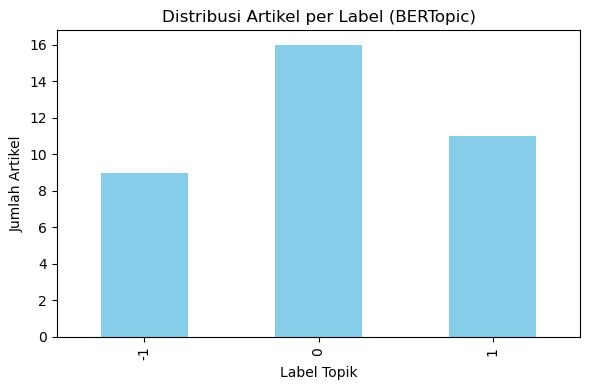

In [23]:
# Visualisasi distribusi artikel per label
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
df["predicted_label"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribusi Artikel per Label (BERTopic)")
plt.xlabel("Label Topik")
plt.ylabel("Jumlah Artikel")
plt.tight_layout()
plt.show()

In [25]:
out.head(10)

,title,content,predicted_label
0,Anthropic Sampai Harus Buka Kantor di India De...,"Saritha Rai-Bloomberg News Bloomberg, Anthropi...",1
1,Sidang Perdana Gugatan Kelangkaan BBM Shell dk...,"Bloomberg Technoz, Jakarta – Menteri Energi da...",0
2,Respons Rosan Soal Stimulus Likuiditas Pasar M...,"Bloomberg Technoz, Jakarta - CEO Badan Pengelo...",0
3,Kata Jaksa Soal Isi Pemeriksaan 2 Perwakilan G...,"Bloomberg Technoz, Jakarta - Kejaksaan Agung b...",0
4,"Daftar Negara Pemilik Emas Terbanyak di Dunia,...","Bloomberg Technoz, Jakarta - Harga emas dunia ...",1
5,Purbaya akan Suntik Dana ke Bank DKI & Bank Ja...,"Bloomberg Technoz, Jakarta - Menteri Keuangan ...",0
6,Menkum Soroti Ketimpangan Royalti dari Spotify...,"Bloomberg Technoz, Jakarta - Penerimaan royalt...",0
7,Bahlil Paraf Draf Perpres Pengolahan Sampah Ja...,"Bloomberg Technoz, Jakarta - Menteri Energi da...",0
8,Fenomena Gray Divorce: Perceraian di Umur 50 T...,"Bloomberg Technoz, Jakarta - Fenomena gray div...",-1
9,Freeport Sebut Nego Divestasi Masih Jalan Mesk...,"Bloomberg Technoz, Jakarta - Presiden Direktur...",0


Dari analisis topik dengan BERTopic dan indoBERT tersebut, dapat dilihat berhasil melakukan distribusi label dimana sebagian artikel dan isi kontennya terklasifikasi ke label 0 dan label 1.